# 排序阶段 EDA：外部特征与关联分析
本笔记本旨在挖掘 TMDb 外部元数据的价值，验证哪些深度特征对预测用户评分最有效。

## 1. 环境准备与数据加载

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pathlib import Path

# 路径修复与中文字体配置
sys.path.append('..')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

data_dir = Path('../data/processed')
tmdb_dir = data_dir / 'tmdb'

# 加载数据
print('正在加载数据...')
ratings = pd.read_parquet(data_dir / 'ratings.parquet')
tmdb_movies = pd.read_parquet(tmdb_dir / 'tmdb_movies.parquet')
tmdb_cast = pd.read_parquet(tmdb_dir / 'tmdb_movie_cast.parquet')
tmdb_crew = pd.read_parquet(tmdb_dir / 'tmdb_movie_crew.parquet')
tmdb_persons = pd.read_parquet(tmdb_dir / 'tmdb_persons.parquet')

print(f'数据加载完成！TMDb 电影数: {len(tmdb_movies):,}')

正在加载数据...
数据加载完成！TMDb 电影数: 86,260


## 2. 数值特征相关性分析

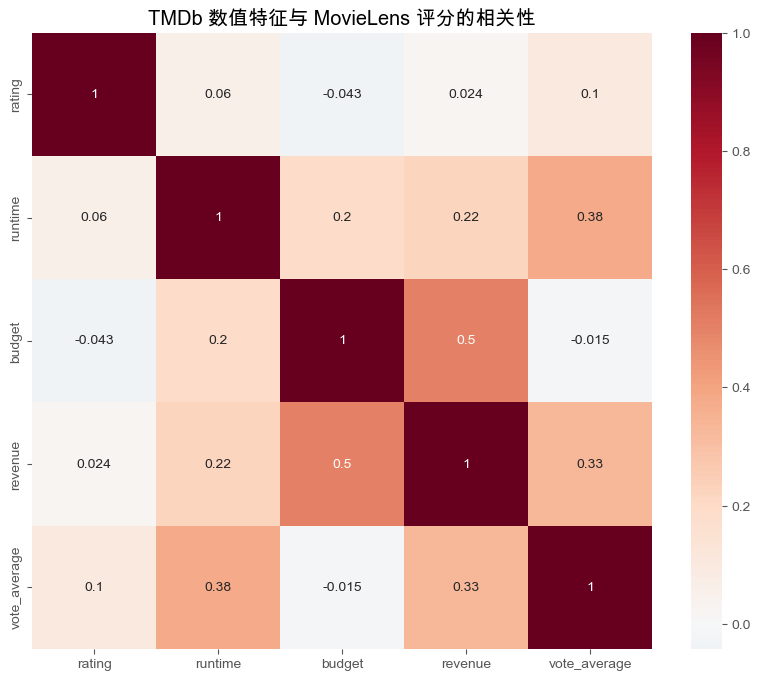

In [2]:
# 为了计算速度，采样 50 万条评分记录进行相关性分析
df_merged = ratings.sample(500000).merge(tmdb_movies, on='movieId', how='inner')

cols_to_corr = ['rating', 'runtime', 'budget', 'revenue', 'vote_average']
corr_matrix = df_merged[cols_to_corr].replace(0, np.nan).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('TMDb 数值特征与 MovieLens 评分的相关性')
plt.show()

## 3. 导演号召力分析

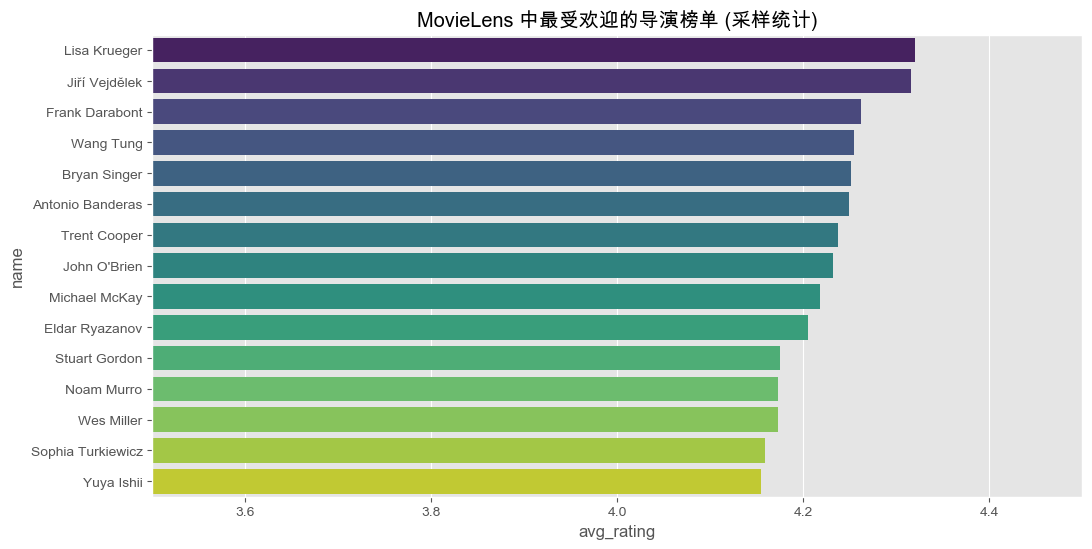

In [3]:
# 统计导演的平均分 (采样 100 万评分以保证速度)
director_scores = tmdb_crew[tmdb_crew['job'] == 'Director'].merge(ratings.sample(1000000), on='movieId')
director_stats = director_scores.groupby('personId').agg({'rating': ['mean', 'count']})
director_stats.columns = ['avg_rating', 'movie_count']

# 筛选有一定代表性的导演
top_directors = director_stats[director_stats['movie_count'] > 100].merge(tmdb_persons, on='personId')
top_directors = top_directors.sort_values('avg_rating', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='name', hue='name', data=top_directors, palette='viridis', legend=False)
plt.title('MovieLens 中最受欢迎的导演榜单 (采样统计)')
plt.xlim(3.5, 4.5)
plt.show()

## 4. 电影语种对评分的影响

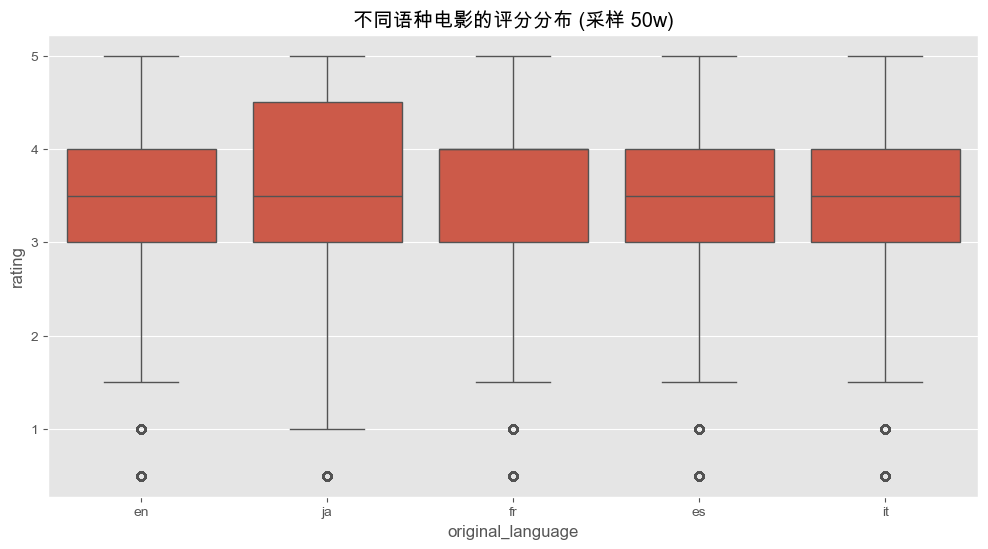

In [4]:
plt.figure(figsize=(12, 6))
# 只统计电影数量较多的前 5 个语种
top_langs = tmdb_movies['original_language'].value_counts().head(5).index
sns.boxplot(x='original_language', y='rating', data=df_merged[df_merged['original_language'].isin(top_langs)])
plt.title('不同语种电影的评分分布 (采样 50w)')
plt.show()

## 5. 用户-物品交叉偏好分析 (User-Item Cross Analysis)
验证“匹配类特征”的威力。我们分析用户是否对特定的导演或制作规模表现出明显的偏好。

In [ ]:
# 5.1 导演忠诚度分析
print('正在计算导演忠诚度样本...')
df_sampled_ratings = ratings.sample(1000000)
df_director_user = tmdb_crew[tmdb_crew['job'] == 'Director'].merge(df_sampled_ratings, on='movieId')

# 统计打分均值和方差
user_dir_stats = df_director_user.groupby(['userId', 'personId']).agg({'rating': ['mean', 'std', 'count']})
user_dir_stats.columns = ['avg_rating', 'std_rating', 'view_count']

# 筛选活跃记录
loyal_fans = user_dir_stats[user_dir_stats['view_count'] >= 3].dropna()

print(f'找到 {len(loyal_fans)} 组『用户-导演』忠诚对。')
print(f'忠诚粉丝打分的平均标准差: {loyal_fans["std_rating"].mean():.4f}')
print(f'全站用户打分的全局标准差: {ratings["rating"].std():.4f}')

In [ ]:
# 5.2 用户制作规模偏好
user_budget_pref = df_merged.groupby('userId').agg({'budget': 'mean', 'rating': 'mean'})
user_budget_pref = user_budget_pref[user_budget_pref['budget'] > 0]

plt.figure(figsize=(10, 6))
sns.regplot(x='budget', y='rating', data=user_budget_pref.sample(min(2000, len(user_budget_pref))), scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xscale('log')
plt.title('用户观影预算偏好与评分的关系')
plt.show()